 # Image Captioning con TensorFlow y Flickr8k



 ## Sistema de descripción automática de imágenes



 **Arquitectura**: Encoder-Decoder con VGG16 + LSTM con atención

 ## 1. CONFIGURACIÓN INICIAL

### Instalar Dependencias

In [1]:
#try:
    #import tensorflow as tf
    #print(f"TensorFlow {tf.__version__} ya está instalado")
#except ImportError:
    #pip install tensorflow numpy matplotlib pillow nltk tqdm pycocotools
    #import tensorflow as tf


### Descargar NLTK

In [2]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to C:\Users\Gerard/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Gerard/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Descargar Dataset

In [3]:
from tqdm import tqdm
import urllib.request
from pathlib import Path
import string

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_file(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

In [4]:
import os
import zipfile
from pathlib import Path


FLICKR_DIR = Path.cwd() / "Flickr8k"
FLICKR_DIR.mkdir(parents=True, exist_ok=True)

# Descargar y extraer imágenes
dataset_zip_path = FLICKR_DIR /"Flickr8k_Dataset.zip"
if not (FLICKR_DIR / "Flicker8k_Dataset").exists():
    if not dataset_zip_path.exists():
        print("📦 Descargando imágenes...")
        download_file(
            "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip",
            dataset_zip_path
        )
    print("📂 Extrayendo imágenes...")
    with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
        zip_ref.extractall(FLICKR_DIR)
else:
    print("📂 Imágenes ya extraídas.")

# Descargar y extraer descripciones
text_zip_path = FLICKR_DIR / "Flickr8k_text.zip"
if not (FLICKR_DIR / "Flickr8k.token.txt").exists():
    if not text_zip_path.exists():
        print("📦 Descargando descripciones...")
        download_file(
            "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip",
            text_zip_path
        )
    print("📂 Extrayendo descripciones...")
    with zipfile.ZipFile(text_zip_path, 'r') as zip_ref:
        zip_ref.extractall(FLICKR_DIR)
else:
    print("📂 Descripciones ya extraídas.")


📂 Imágenes ya extraídas.
📂 Descripciones ya extraídas.


 ## 2. IMPORTS Y CONFIGURACIÓN

### Importes Principales

In [5]:
import os
import numpy as np
from pathlib import Path
from PIL import Image
import tensorflow as tf
import string
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import datetime
import re
from collections import Counter
import ssl
import nltk 
import datetime

### Tensorflow / NLTK

In [6]:
from tensorflow.keras.layers import (Input, Dense, Embedding, LSTM, Concatenate,  Dropout, BatchNormalization, Layer, GlobalAveragePooling2D)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Concatenate, Dropout, LayerNormalization, Bidirectional, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.initializers import HeNormal
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from tqdm import tqdm
from IPython.display import display, Markdown

### Recursos NLTK

In [7]:
# Configuración SSL para NLTK
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Descargar recursos NLTK (versión mejorada)
def setup_nltk():
    required_resources = {
        'punkt': ['tokenizers/punkt'],
        'wordnet': ['corpora/wordnet'],
        'averaged_perceptron_tagger': ['taggers/averaged_perceptron_tagger'],
        'stopwords': ['corpora/stopwords']
    }
    
    print("Configurando recursos NLTK...")
    
    # Verificar si los datos están en la ubicación correcta
    nltk_data_path = os.path.join(os.path.expanduser("~"), "nltk_data")
    if not os.path.exists(nltk_data_path):
        os.makedirs(nltk_data_path)
    for resource, subpaths in required_resources.items():
        try:
            # Verificar si ya está descargado
            all_downloaded = True
            for subpath in subpaths:
                try:
                    nltk.data.find(subpath)
                except LookupError:
                    all_downloaded = False
                    break
            
            if not all_downloaded:
                print(f"Descargando recurso: {resource}...")
                nltk.download(resource, quiet=False)
                print(f"Recurso {resource} instalado correctamente")
            else:
                print(f"Recurso {resource} ya está instalado")
                
        except Exception as e:
            print(f"\n⚠️ Error al configurar {resource}: {str(e)}")
            print("Puedes intentar descargarlo manualmente con:")
            print(f"import nltk; nltk.download('{resource}')\n")

setup_nltk()

Configurando recursos NLTK...
Recurso punkt ya está instalado
Descargando recurso: wordnet...
Recurso wordnet instalado correctamente
Recurso averaged_perceptron_tagger ya está instalado
Recurso stopwords ya está instalado


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gerard/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Configuracion de Directorios

In [8]:
class Config:
    def __init__(self):
        # Ruta base en tu directorio personal
        self.BASE_DIR = Path.cwd() / "Flickr8k"
        self.IMAGE_DIR = self.BASE_DIR / "Flicker8k_Dataset"
        self.TRAIN_FILE = self.BASE_DIR / "Flickr_8k.trainImages.txt"
        self.TEST_FILE = self.BASE_DIR / "Flickr_8k.testImages.txt"
        self.DESCRIPTIONS_FILE = self.BASE_DIR / "Flickr8k.token.txt"
        
        # Verificar existencia de directorios y archivos
        self._verify_paths()

    def _verify_paths(self):
        """Verifica que los paths existan"""
        required_paths = {
            "Directorio base": self.BASE_DIR,
            "Directorio de imágenes": self.IMAGE_DIR,
            "Archivo de entrenamiento": self.TRAIN_FILE,
            "Archivo de prueba": self.TEST_FILE,
            "Archivo de descripciones": self.DESCRIPTIONS_FILE
        }
        
        missing = False
        for name, path in required_paths.items():
            if not path.exists():
                print(f"❌ {name} no encontrado en: {path}")
                missing = True
            else:
                print(f"✅ {name} encontrado: {path}")
        
        if missing:
            raise FileNotFoundError("Faltan archivos/directorios requeridos. Verifica las rutas.")

config = Config()
ACTUAL_DIR = Path.cwd()


✅ Directorio base encontrado: c:\Users\Gerard\Desktop\VISUAL_STUDIO\Proyecto_Final_MIA\Flickr8k
✅ Directorio de imágenes encontrado: c:\Users\Gerard\Desktop\VISUAL_STUDIO\Proyecto_Final_MIA\Flickr8k\Flicker8k_Dataset
✅ Archivo de entrenamiento encontrado: c:\Users\Gerard\Desktop\VISUAL_STUDIO\Proyecto_Final_MIA\Flickr8k\Flickr_8k.trainImages.txt
✅ Archivo de prueba encontrado: c:\Users\Gerard\Desktop\VISUAL_STUDIO\Proyecto_Final_MIA\Flickr8k\Flickr_8k.testImages.txt
✅ Archivo de descripciones encontrado: c:\Users\Gerard\Desktop\VISUAL_STUDIO\Proyecto_Final_MIA\Flickr8k\Flickr8k.token.txt


 ## 3. PREPARAR DATOS

### Cargar Datos en Variables

In [9]:
def load_image_ids(file_path):
    """Carga IDs de imágenes desde archivo"""
    if not file_path.exists():
        raise FileNotFoundError(f"Archivo no encontrado: {file_path}")
    
    with open(file_path, 'r', encoding='utf-8') as f:
        return [line.strip().split('.')[0] for line in f if line.strip()]

def load_descriptions(file_path):
    """Carga y normaliza descripciones"""
    descriptions = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line or '\t' not in line:
                continue
                
            img_id, desc = line.split('\t')
            img_id = img_id.split('.')[0]
            desc = desc.lower().translate(str.maketrans('', '', string.punctuation))
            
            descriptions.setdefault(img_id, []).append(desc)
    
    return descriptions

# Cargar datos
train_ids = load_image_ids(config.TRAIN_FILE)
test_ids = load_image_ids(config.TEST_FILE)
all_descriptions = load_descriptions(config.DESCRIPTIONS_FILE)

# Filtrar descripciones
train_descriptions = {k: all_descriptions[k] for k in train_ids if k in all_descriptions}
test_descriptions = {k: all_descriptions[k] for k in test_ids if k in all_descriptions}

print(f"✔ Imágenes de entrenamiento: {len(train_ids)}")
print(f"✔ Imágenes de prueba: {len(test_ids)}")
print(f"✔ Descripciones de entrenamiento: {len(train_descriptions)}")
print(f"✔ Descripciones de prueba: {len(test_descriptions)}")


✔ Imágenes de entrenamiento: 6000
✔ Imágenes de prueba: 1000
✔ Descripciones de entrenamiento: 6000
✔ Descripciones de prueba: 1000


 ## 4. VOCABULARIO

### Crear Vocabulario

In [10]:
def build_vocabulary(descriptions, min_count=5):  # Cambiado de 3 a 5 para reducir vocabulario ruidoso
    """Construye vocabulario con filtrado mejorado"""
    word_counts = Counter()
    
    for desc_list in tqdm(descriptions.values(), desc="Procesando descripciones"):
        for desc in desc_list:
            # Mejor filtrado de tokens
            tokens = word_tokenize(desc.lower())
            tokens = [t for t in tokens if t.isalpha() and len(t) > 1]  # Excluir palabras de 1 letra
            word_counts.update(tokens)
    
    # Vocabulario más robusto
    vocab = ['<start>', '<end>', '<pad>', '<unk>'] + \
            [word for word, count in word_counts.items() if count >= min_count]
    
    print(f"\nVocabulario creado: {len(vocab)} palabras")
    print("20 palabras más frecuentes:", word_counts.most_common(20))
    
    return vocab, {word: idx for idx, word in enumerate(vocab)}, \
        {idx: word for idx, word in enumerate(vocab)}

vocabulary, word_to_idx, idx_to_word = build_vocabulary(train_descriptions, min_count=3)
vocab_size = len(vocabulary)


Procesando descripciones: 100%|██████████| 6000/6000 [00:01<00:00, 4091.82it/s]


Vocabulario creado: 3473 palabras
20 palabras más frecuentes: [('in', 14085), ('the', 13509), ('on', 8006), ('is', 6907), ('and', 6672), ('dog', 6159), ('with', 5763), ('man', 5374), ('of', 4967), ('two', 4246), ('white', 2921), ('black', 2854), ('boy', 2634), ('are', 2619), ('woman', 2543), ('girl', 2414), ('to', 2303), ('wearing', 2271), ('at', 2101), ('people', 2093)]


 ## 5. PREPROCESAMIENTO

### Encoder

In [11]:
def create_encoder(trainable_layers=6):
    base_model = tf.keras.applications.EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_shape=(300, 300, 3),
        pooling='avg'
    )
    
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False
        
    x = base_model.output
    x = Dense(512, activation='swish', kernel_initializer='he_normal')(x)
    x = LayerNormalization()(x)
    x = Dropout(0.2)(x)
    
    return Model(inputs=base_model.input, outputs=x)


In [12]:
encoder = create_encoder(trainable_layers=6)
print("✔ Encoder creado con EfficientNetB3")

✔ Encoder creado con EfficientNetB3


### Descripciones

In [13]:
def preprocess_descriptions(descriptions, word_to_idx, max_length=None):
    """Convierte texto a secuencias de índices y calcula longitud máxima"""
    
    processed = {}
    calculated_max_length = 0 if max_length is None else max_length
    
    # Pre-compilar regex para mejor performance
    clean_pattern = re.compile(r'[^a-zA-Z\s]')
    
    for img_id, desc_list in tqdm(descriptions.items(), desc="Preprocesando descripciones"):
        processed[img_id] = []
        
        for desc in desc_list:
            # Limpieza más robusta del texto
            desc = clean_pattern.sub('', desc.lower()).strip()
            
            # Tokenización con manejo de errores
            try:
                words = word_tokenize(desc)
            except:
                words = desc.split()  # Fallback básico
            
            # Convertir palabras a índices con manejo de OOV
            seq = []
            for word in words:
                if word in word_to_idx:
                    seq.append(word_to_idx[word])
                else:
                    # Manejo de palabras fuera de vocabulario
                    if word.isalpha():  # Solo si es una palabra real
                        seq.append(word_to_idx.get('<unk>', 0))
            
            # Actualizar máxima longitud si es necesario
            if max_length is None and len(seq) > calculated_max_length:
                calculated_max_length = len(seq)
            
            # Filtrar secuencias vacías
            if len(seq) > 0:
                processed[img_id].append(seq)
    
    # Asegurar que tenemos al menos 1 como longitud mínima
    final_max_length = max(1, calculated_max_length)
    
    print(f"\nProcesadas {len(processed)} imágenes")
    print(f"Longitud máxima de secuencia: {final_max_length}")
    
    return processed, final_max_length
 
# Preprocesar descripciones con versión corregida
train_descriptions_processed, max_seq_length = preprocess_descriptions(train_descriptions, word_to_idx)
test_descriptions_processed, _ = preprocess_descriptions(test_descriptions, word_to_idx)
# Guardar test_descriptions_processed para uso posterior como pkl
import pickle
with open(ACTUAL_DIR / "test_descriptions_processed.pkl", 'wb') as f:
    pickle.dump(test_descriptions_processed, f)
print(f"\nLongitud máxima de secuencia: {max_seq_length}")


Preprocesando descripciones:   0%|          | 0/6000 [00:00<?, ?it/s]

Preprocesando descripciones: 100%|██████████| 6000/6000 [00:01<00:00, 4091.61it/s]



Procesadas 6000 imágenes
Longitud máxima de secuencia: 35


Preprocesando descripciones: 100%|██████████| 1000/1000 [00:00<00:00, 4169.16it/s]


Procesadas 1000 imágenes
Longitud máxima de secuencia: 31

Longitud máxima de secuencia: 35


### Caracteristicas (con Aumento)

In [ ]:
# Configurar aumento de datos
train_datagen = ImageDataGenerator(
    rotation_range=25,  # Aumentado
    width_shift_range=0.15,
    height_shift_range=0.15,
    brightness_range=[0.8, 1.2],  # Nuevo
    zoom_range=0.2,
    fill_mode='constant',  # Rellenar con negro
    cval=0.0
)

def augmented_extract_features(image_ids, image_dir):
    """Extrae características con aumento de datos"""
    features = {}
    for img_id in tqdm(image_ids, desc="Extrayendo características (con aumento)"):
        img_path = image_dir / f"{img_id}.jpg"
        img = Image.open(img_path).convert('RGB')
        img = img.resize((300, 300))
        
        # Extraer características de la imagen original
        img_array = np.expand_dims(np.array(img) / 255.0, axis=0)
        img_array = preprocess_input(img_array)
        features[img_id] = encoder.predict(img_array, verbose=0)[0]
        
        # Generar una versión aumentada
        aug_img_array = train_datagen.random_transform(img_array[0])
        aug_img_array = preprocess_input(np.expand_dims(aug_img_array, axis=0))
        features[f"{img_id}_aug"] = encoder.predict(aug_img_array, verbose=0)[0]
    
    return features

# Reemplazar la extracción original (opcional, comentar si es muy lento)
train_features = augmented_extract_features(train_ids, config.IMAGE_DIR)
test_features = augmented_extract_features(test_ids, config.IMAGE_DIR)

Extrayendo características (con aumento):  67%|██████▋   | 4000/6000 [22:07<09:39,  3.45it/s]

### Cargar Caracteristicas

In [37]:
# cargar características
def load_features(filename):
    with open(filename, 'rb') as f:
        return np.load(f, allow_pickle=True).item()

In [38]:
#train_features = load_features(ACTUAL_DIR / "features" / "train_features.npy")
#test_features = load_features(ACTUAL_DIR / "features" / "test_features.npy")

### Guardar Caracteristicas

In [39]:
# guardar características
def save_features(features, filename):
    with open(filename, 'wb') as f:
        np.save(f, features)

In [40]:
save_features(train_features, ACTUAL_DIR / "features" / "train_features_final.npy")
save_features(test_features, ACTUAL_DIR /"features" / "test_features_final.npy")

### Preprocesar Descripciones

In [41]:
def preprocess_descriptions(descriptions, word_to_idx, max_length=None):
    """Convierte texto a secuencias de índices y calcula longitud máxima"""
    
    processed = {}
    calculated_max_length = 0 if max_length is None else max_length
    
    # Pre-compilar regex para mejor performance
    clean_pattern = re.compile(r'[^a-zA-Z\s]')
    
    for img_id, desc_list in tqdm(descriptions.items(), desc="Preprocesando descripciones"):
        processed[img_id] = []
        
        for desc in desc_list:
            # Limpieza más robusta del texto
            desc = clean_pattern.sub('', desc.lower()).strip()
            
            # Tokenización con manejo de errores
            try:
                words = word_tokenize(desc)
            except:
                words = desc.split()  # Fallback básico
            
            # Convertir palabras a índices con manejo de OOV
            seq = []
            for word in words:
                if word in word_to_idx:
                    seq.append(word_to_idx[word])
                else:
                    # Manejo de palabras fuera de vocabulario
                    if word.isalpha():  # Solo si es una palabra real
                        seq.append(word_to_idx.get('<unk>', 0))
            
            # Actualizar máxima longitud si es necesario
            if max_length is None and len(seq) > calculated_max_length:
                calculated_max_length = len(seq)
            
            # Filtrar secuencias vacías
            if len(seq) > 0:
                processed[img_id].append(seq)
    
    # Asegurar que tenemos al menos 1 como longitud mínima
    final_max_length = max(1, calculated_max_length)
    
    print(f"\nProcesadas {len(processed)} imágenes")
    print(f"Longitud máxima de secuencia: {final_max_length}")
    
    return processed, final_max_length

 ## 8. CREAR TENSORFLOW DATASET

In [42]:
def create_tf_dataset(descriptions, features, batch_size=64):
    def gen():
        for img_id, desc_list in descriptions.items():
            feature = features[img_id]
            for desc in desc_list:
                # Secuencia completa de entrenamiento
                caption_input = desc[:-1]  # Todo menos la última palabra
                caption_target = desc[1:]  # Todo menos la primera palabra

                # Devuelve las secuencias de entrada y objetivo
                yield {
                    'image_features': feature,
                    'caption_input': pad_sequences([caption_input], maxlen=max_seq_length, padding='post')[0]
                }, pad_sequences([caption_target], maxlen=max_seq_length, padding='post')[0]
    
    return tf.data.Dataset.from_generator(
        gen,
        output_signature=(
            {
                'image_features': tf.TensorSpec(shape=(512,), dtype=tf.float32),
                'caption_input': tf.TensorSpec(shape=(max_seq_length,), dtype=tf.int32)
            },
            tf.TensorSpec(shape=(max_seq_length,), dtype=tf.int32)
        )
    ).shuffle(2000).batch(batch_size).prefetch(2).repeat()


# Crear datasets con repeat=True
train_dataset = create_tf_dataset(train_descriptions_processed,train_features)
val_dataset = create_tf_dataset(test_descriptions_processed, test_features)

Tamaño del vocabulario: 3473
Las 20 palabras más frecuentes en el vocabulario:
<unk>: 52216
in: 14085
the: 13509
on: 8006
is: 6907
and: 6672
dog: 6159
with: 5763
man: 5374
of: 4967
two: 4246
white: 2921
black: 2854
boy: 2634
are: 2619
woman: 2543
girl: 2414
to: 2303
wearing: 2271
at: 2101
Total de palabras fuera de vocabulario (OOV): 323518
Longitud máxima de secuencias: 35
Longitud mínima de secuencias: 2
Promedio de longitud de secuencias: 10.783933333333334


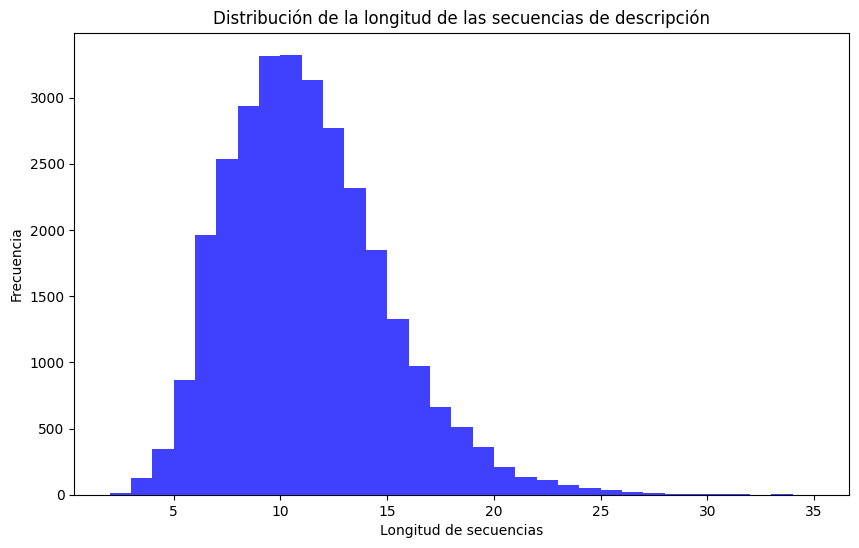

In [ ]:
def vocab_diagnostics(vocab, train_descriptions_processed, word_to_idx, max_length):
    """
    Diagnóstico sobre el vocabulario y las descripciones.
    """
    # 1. Calcular la frecuencia de las palabras en las descripciones
    all_words = [word for desc_list in train_descriptions_processed.values() for desc in desc_list for word in desc]
    word_counts = Counter(all_words)  # Cuenta las ocurrencias de cada palabra

    # 2. Verificar el tamaño del vocabulario
    print(f"Tamaño del vocabulario: {len(vocab)}")
    
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}

    # Muestra las 20 palabras más frecuentes con sus respectivos índices
    print("Las 20 palabras más frecuentes en el vocabulario:")
    for idx, count in word_counts.most_common(20):
        word = idx_to_word.get(idx, "<unk>")
        print(f"{word}: {count}")


    # 4. Verificar el número de palabras fuera de vocabulario (<unk>)
    oov_count = sum(1 for desc_list in train_descriptions_processed.values() for desc in desc_list
                    for word in desc if word_to_idx.get(word, word_to_idx['<unk>']) == word_to_idx['<unk>'])
    print(f"Total de palabras fuera de vocabulario (OOV): {oov_count}")

    # 5. Verificar la longitud de las secuencias
    seq_lengths = [len(seq) for desc_list in train_descriptions_processed.values() for seq in desc_list]
    print(f"Longitud máxima de secuencias: {max(seq_lengths)}")
    print(f"Longitud mínima de secuencias: {min(seq_lengths)}")
    print(f"Promedio de longitud de secuencias: {np.mean(seq_lengths)}")
    
    # 6. Graficar la distribución de la longitud de las secuencias
    plt.figure(figsize=(10, 6))
    plt.hist(seq_lengths, bins=range(min(seq_lengths), max(seq_lengths) + 1, 1), alpha=0.75, color='blue')
    plt.title("Distribución de la longitud de las secuencias de descripción")
    plt.xlabel("Longitud de secuencias")
    plt.ylabel("Frecuencia")
    plt.show()

# Ejemplo de cómo llamar a la función (asegurándote de tener los datos preprocesados)
vocab_diagnostics(vocabulary, train_descriptions_processed, word_to_idx, max_seq_length)



 ## 9. ENTRENAMIENTO

### BahdanauAttention

In [44]:
class BahdanauAttention(Layer):
    def __init__(self, units, **kwargs):
        super(BahdanauAttention, self).__init__(**kwargs)
        self.W1 = Dense(units, kernel_initializer='he_normal')
        self.W2 = Dense(units, kernel_initializer='he_normal')
        self.V = Dense(1, kernel_initializer='he_normal')
        self.units = units

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = self.V(tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis)
        ))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights
    

### Decoder

In [45]:
from keras.layers import Input, Embedding, LSTM, Dropout, Dense, Concatenate, RepeatVector, Reshape
from keras.models import Model

def create_decoder(vocab_size, max_length, embedding_dim=256, lstm_units=512, dropout_rate=0.5):
    # 1. Entradas
    caption_input = Input(shape=(max_length,), name='caption_input')  # Ajustado el nombre
    image_features = Input(shape=(512,), name='image_features')
    # 2. Embedding para el caption
    caption_emb = Embedding(vocab_size, embedding_dim, mask_zero=True)(caption_input)

    # 3. LSTM para procesar el caption embebido
    lstm_out = LSTM(lstm_units, return_sequences=True)(caption_emb)
    lstm_out = Dropout(dropout_rate)(lstm_out)

    # 4. Contexto a partir de LSTM (simple atención simulada como promedio, puedes usar real atención)
    context_vector = Dense(lstm_units, activation='tanh')(lstm_out[:, -1, :])  # Último timestep

    # 5. Expandir contexto e imagen
    context_exp = RepeatVector(max_length)(context_vector)  # (batch, max_length, lstm_units)
    image_exp = RepeatVector(max_length)(image_features)    # (batch, max_length, embedding_dim)

    # 6. Combinar contexto + imagen + LSTM output
    merged = Concatenate()([context_exp, image_exp, lstm_out])  # (batch, max_length, lstm_units + embedding_dim + lstm_units)

    # 7. Salida densa
    x = Dense(512, activation='relu')(merged)
    output = Dense(vocab_size, activation='softmax')(x)

    model = Model(inputs=[caption_input, image_features], outputs=output)
    return model


In [46]:
# 1. Definir parámetros
vocab_size = len(vocabulary)
max_seq_length = 35  # Ajustar según tu dataset

# 2. Crear modelo
decoder = create_decoder(vocab_size, max_seq_length)

# 3. Compilar con configuración optimizada
decoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Verificar con un batch de prueba
test_batch = next(iter(train_dataset.take(1)))
try:
    decoder(test_batch[0])
    print("✅ Modelo creado correctamente")
except Exception as e:
    print(f"❌ Error: {str(e)}")

✅ Modelo creado correctamente


### LEARNING RATE

In [47]:
def lr_schedule(epoch):
    """Planificación del learning rate corregida"""
    warmup_epochs = 8
    decay_epochs = 30
    base_lr = 5e-4
    min_lr = 1e-6
    
    if epoch < warmup_epochs:
        lr = float(base_lr * (epoch + 1) / warmup_epochs)
    elif epoch < decay_epochs:
        progress = float(epoch - warmup_epochs) / (decay_epochs - warmup_epochs)
        lr = float(base_lr * 0.5 * (1 + np.cos(np.pi * progress)))
    else:
        lr = float(min_lr)
    
    return lr

### Optimizer / Loss Function

In [48]:
from tensorflow.keras.optimizers import Adam

# Crear un nuevo optimizador
optimizer = Adam(
    learning_rate=5e-4,
    clipnorm=1.0
)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)


### Callbacks

In [49]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    #ModelCheckpoint('best_model_checkpoint.keras', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    LearningRateScheduler(lr_schedule),
    TensorBoard(log_dir='./logs')
]

In [50]:
decoder = create_decoder(vocab_size, max_seq_length)
decoder.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['accuracy']
)


### Hiperparametros

In [51]:
for batch in train_dataset.take(1):
    (inputs, targets) = batch
    print("caption_input:", inputs["caption_input"].shape)
    print("image_features:", inputs["image_features"].shape)
    print("targets:", targets.shape)


caption_input: (64, 35)
image_features: (64, 512)
targets: (64, 35)


2025-05-12 13:14:30.639417: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [52]:
BATCH_SIZE = 64
EPOCHS = 35
train_steps = len(train_descriptions_processed) // BATCH_SIZE
val_steps = len(test_descriptions_processed) // BATCH_SIZE


### Entrenamientos

In [ ]:
# Activar la ejecución eager si no está habilitada (he tenido problemas con esto, en teoria activando esto deberia ir bien)
tf.config.experimental_run_functions_eagerly(True)


Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [54]:
# Main training
print("Starting main training...")
history = decoder.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    validation_data=val_dataset,
    validation_steps=val_steps,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# Fine-tuning phase
print("\nStarting fine-tuning...")
for layer in encoder.layers[-4:]:
    layer.trainable = True

decoder.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=loss_fn,
    metrics=['accuracy']
)

history_finetune = decoder.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    validation_data=val_dataset,
    validation_steps=val_steps,
    initial_epoch=EPOCHS,
    epochs=EPOCHS + 2,
    callbacks=callbacks,
    verbose=1
)

Starting main training...
Epoch 1/35


2025-05-12 13:14:31.780596: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 455213056 exceeds 10% of free system memory.
2025-05-12 13:14:31.931562: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201326592 exceeds 10% of free system memory.


 1/93 ━━━━━━━━━━━━━━━━━━━━ 2:47 2s/step - accuracy: 8.9286e-04 - loss: 7.9060

2025-05-12 13:14:32.919858: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 455213056 exceeds 10% of free system memory.
2025-05-12 13:14:33.062187: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201326592 exceeds 10% of free system memory.


 2/93 ━━━━━━━━━━━━━━━━━━━━ 1:28 977ms/step - accuracy: 6.6964e-04 - loss: 7.8819

2025-05-12 13:14:33.856331: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 455213056 exceeds 10% of free system memory.


93/93 ━━━━━━━━━━━━━━━━━━━━ 93s 992ms/step - accuracy: 0.5755 - loss: 5.6223 - val_accuracy: 0.7173 - val_loss: 2.1808 - learning_rate: 6.2500e-05
Epoch 2/35
93/93 ━━━━━━━━━━━━━━━━━━━━ 90s 971ms/step - accuracy: 0.7237 - loss: 2.1027 - val_accuracy: 0.7350 - val_loss: 1.8109 - learning_rate: 1.2500e-04
Epoch 3/35
93/93 ━━━━━━━━━━━━━━━━━━━━ 91s 978ms/step - accuracy: 0.7401 - loss: 1.7623 - val_accuracy: 0.7421 - val_loss: 1.7005 - learning_rate: 1.8750e-04
Epoch 4/35
93/93 ━━━━━━━━━━━━━━━━━━━━ 91s 978ms/step - accuracy: 0.7419 - loss: 1.7103 - val_accuracy: 0.7464 - val_loss: 1.6767 - learning_rate: 2.5000e-04
Epoch 5/35
93/93 ━━━━━━━━━━━━━━━━━━━━ 90s 970ms/step - accuracy: 0.7471 - loss: 1.6685 - val_accuracy: 0.7440 - val_loss: 1.6560 - learning_rate: 3.1250e-04
Epoch 6/35
93/93 ━━━━━━━━━━━━━━━━━━━━ 91s 979ms/step - accuracy: 0.7462 - loss: 1.6655 - val_accuracy: 0.7525 - val_loss: 1.6111 - learning_rate: 3.7500e-04
Epoch 7/35
93/93 ━━━━━━━━━━━━━━━━━━━━ 91s 978ms/step - accuracy: 0.75

 ## 10. Gráfico del entrenamiento

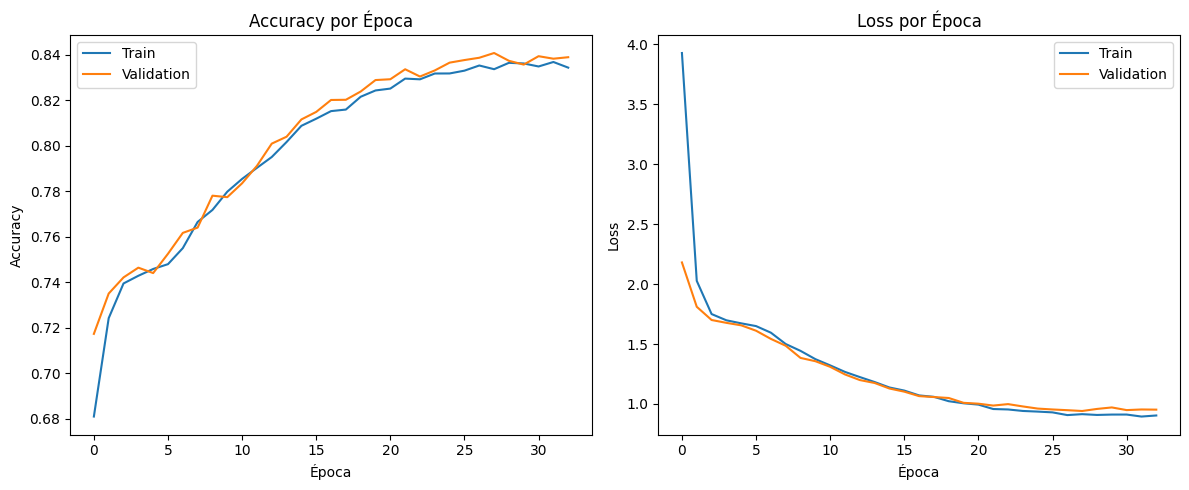

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 5))

# Gráfico de Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy por Época')
plt.ylabel('Accuracy')
plt.xlabel('Época')
plt.legend()

# Gráfico de Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss por Época')
plt.ylabel('Loss')
plt.xlabel('Época')
plt.legend()

plt.tight_layout()
plt.show()
# Guardar el grafico
plt.savefig(ACTUAL_DIR / "graphs" / "training_history.png")

## 11. Guardar Modelo

In [ ]:
date = datetime.datetime.now().strftime("%d_%m")
# Guardar el modelo
if not (ACTUAL_DIR / 'models').exists():
    (ACTUAL_DIR / 'models').mkdir(parents=True, exist_ok=True)
decoder.save(ACTUAL_DIR /'models'/ f'model_final_{date}.keras')
print(f"Modelo guardado en: {ACTUAL_DIR /'models'/ f'model_final_{date}.keras'}")


# Guardar vocabulario, índices y longitud máxima de secuencia
vocab_data = {
    'vocabulary': vocabulary,
    'word_to_idx': word_to_idx,
    'idx_to_word': idx_to_word,
    'max_seq_length': max_seq_length
}

VOCAB_PATH = ACTUAL_DIR /"vocab"/ "vocab_final.pkl"
with open(VOCAB_PATH, "wb") as f:
    pickle.dump(vocab_data, f)

print(f"✔ Vocabulario guardado en: {VOCAB_PATH}")


NameError: name 'ACTUAL_DIR' is not defined